In [1]:
# B92 vs BB84 Quantum Key Distribution Research Project
# E91 Implementation with Ideal, Noise, and Eavesdropping Cases

# =============================================================================
# CELL 1: Setup and Imports for B92
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional, Union
import random
import time
from collections import Counter, defaultdict
from dataclasses import dataclass, field
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Try to import Cirq, install if not available
try:
    import cirq
    print("Cirq already installed.")
except ImportError:
    print("Installing Cirq...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cirq"])
    import cirq
    print("Cirq installed successfully.")

# Additional imports for advanced analysis
from abc import ABC, abstractmethod
import scipy.stats as stats
from scipy.optimize import minimize_scalar

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Set up matplotlib styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Cirq version: {cirq.__version__}")
print("Setup complete. Ready to simulate E91 protocol.")

Installing Cirq...
Cirq installed successfully.
All libraries imported successfully!
Cirq version: 1.6.0
Setup complete. Ready to simulate E91 protocol.


In [2]:
# Cell 2: E91 Ideal Case Implementation

class E91IdealSimulator:
    def __init__(self):
        self.qa = cirq.NamedQubit('qA')
        self.qb = cirq.NamedQubit('qB')
        self.simulator = cirq.Simulator()
        self.reset_protocol()

    def reset_protocol(self):
        self.alice_bases = []
        self.bob_bases = []
        self.alice_measured_bits = []
        self.bob_measured_bits = []
        self.alice_sifted_key = []
        self.bob_sifted_key = []
        self.correlation_matrix = {}

    def create_entangled_pair(self) -> cirq.Circuit:
        circuit = cirq.Circuit()
        circuit.append(cirq.H(self.qa))
        circuit.append(cirq.CNOT(self.qa, self.qb))
        return circuit

    def measure_qubit(self, qubit: cirq.Qid, angle_radians: float, key: str) -> cirq.Circuit:
        """
        Apply rotation to measurement basis and measure in Z.
        angle is rotation around Y axis (Ry), turning Z-basis to desired angle.
        """
        circuit = cirq.Circuit()
        circuit.append(cirq.ry(-angle_radians)(qubit))
        circuit.append(cirq.measure(qubit, key=key))
        return circuit

    def calculate_correlation(self, setting: tuple, bit_a: int, bit_b: int):
        if setting not in self.correlation_matrix:
            self.correlation_matrix[setting] = []

        # Convert 0 → +1, 1 → -1
        a_val = 1 if bit_a == 0 else -1
        b_val = 1 if bit_b == 0 else -1
        self.correlation_matrix[setting].append(a_val * b_val)

    def compute_chsh(self):
        E = lambda a, b: np.mean(self.correlation_matrix.get((a, b), [0]))
        S = abs(E(0, 0) + E(0, 1) + E(1, 0) - E(1, 1))
        return S

    def simulate_e91(self, num_pairs=500):
        self.reset_protocol()
        np.random.seed(int(time.time() * 1000) % 2**32)

        # Define angles (in radians)
        alice_angles = [0, np.pi / 4]         # 0°, 45°
        bob_angles = [np.pi / 8, -np.pi / 8]  # 22.5°, -22.5°

        for _ in range(num_pairs):
            a_idx = random.randint(0, 1)
            b_idx = random.randint(0, 1)

            # Build circuit
            circuit = self.create_entangled_pair()
            circuit += self.measure_qubit(self.qa, alice_angles[a_idx], 'Alice')
            circuit += self.measure_qubit(self.qb, bob_angles[b_idx], 'Bob')

            # Simulate
            result = self.simulator.run(circuit, repetitions=1)
            bit_a = int(result.measurements['Alice'][0][0])
            bit_b = int(result.measurements['Bob'][0][0])

            self.alice_bases.append(a_idx)
            self.bob_bases.append(b_idx)
            self.alice_measured_bits.append(bit_a)
            self.bob_measured_bits.append(bit_b)

            # Calculate correlation
            self.calculate_correlation((a_idx, b_idx), bit_a, bit_b)

            # Sift key: only when a_idx == b_idx (for simplicity here)
            if a_idx == b_idx:
                self.alice_sifted_key.append(bit_a)
                self.bob_sifted_key.append(bit_a)

        return {
            'alice_bases': self.alice_bases,
            'bob_bases': self.bob_bases,
            'alice_results': self.alice_measured_bits,
            'bob_results': self.bob_measured_bits,
            'alice_sifted_key': self.alice_sifted_key,
            'bob_sifted_key': self.bob_sifted_key,
            'sifted_key_length': len(self.alice_sifted_key),
            'raw_key_length': num_pairs,
            'chsh_value': self.compute_chsh()
        }

e91_sim = E91IdealSimulator()

print("Running E91 Simulation (Ideal Case) with CHSH Test")
results = e91_sim.simulate_e91(num_pairs=500)

print(f"Total entangled pairs: 500")
print(f"Sifted key bits: {results['sifted_key_length']}")
print(f"First 10 Alice key bits: {results['alice_sifted_key'][:10]}")
print(f"First 10 Bob key bits: {results['bob_sifted_key'][:10]}")
print(f"CHSH value: {results['chsh_value']:.3f}")

# Check if CHSH value exceeds the classical bound
if results['chsh_value'] > 2:
    print("Bell inequality violated! Entanglement confirmed.")
else:
    print("No violation of Bell inequality.")

Running E91 Simulation (Ideal Case) with CHSH Test
Total entangled pairs: 500
Sifted key bits: 252
First 10 Alice key bits: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
First 10 Bob key bits: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
CHSH value: 2.362
Bell inequality violated! Entanglement confirmed.



E91 METRICS AND ANALYSIS
Running comprehensive analysis: 20 runs with 200 bits each
------------------------------------------------------------
Run  2: Key rate = 0.510, QBER = 0.000, Sifted bits = 102CHSH = 2.3929971988795513
Run  4: Key rate = 0.515, QBER = 0.000, Sifted bits = 103CHSH = 2.153199380438674
Run  6: Key rate = 0.520, QBER = 0.000, Sifted bits = 104CHSH = 2.388148148148148
Run  8: Key rate = 0.545, QBER = 0.000, Sifted bits = 109CHSH = 2.4342908762420956
Run 10: Key rate = 0.535, QBER = 0.000, Sifted bits = 107CHSH = 2.5314510651235906
Run 12: Key rate = 0.475, QBER = 0.000, Sifted bits = 95CHSH = 2.7010861085872593
Run 14: Key rate = 0.520, QBER = 0.000, Sifted bits = 104CHSH = 2.675602060020793
Run 16: Key rate = 0.520, QBER = 0.000, Sifted bits = 104CHSH = 2.356257072942403
Run 18: Key rate = 0.505, QBER = 0.000, Sifted bits = 101CHSH = 2.3657689530979313
Run 20: Key rate = 0.515, QBER = 0.000, Sifted bits = 103CHSH = 2.384586466165414

-----------------------------

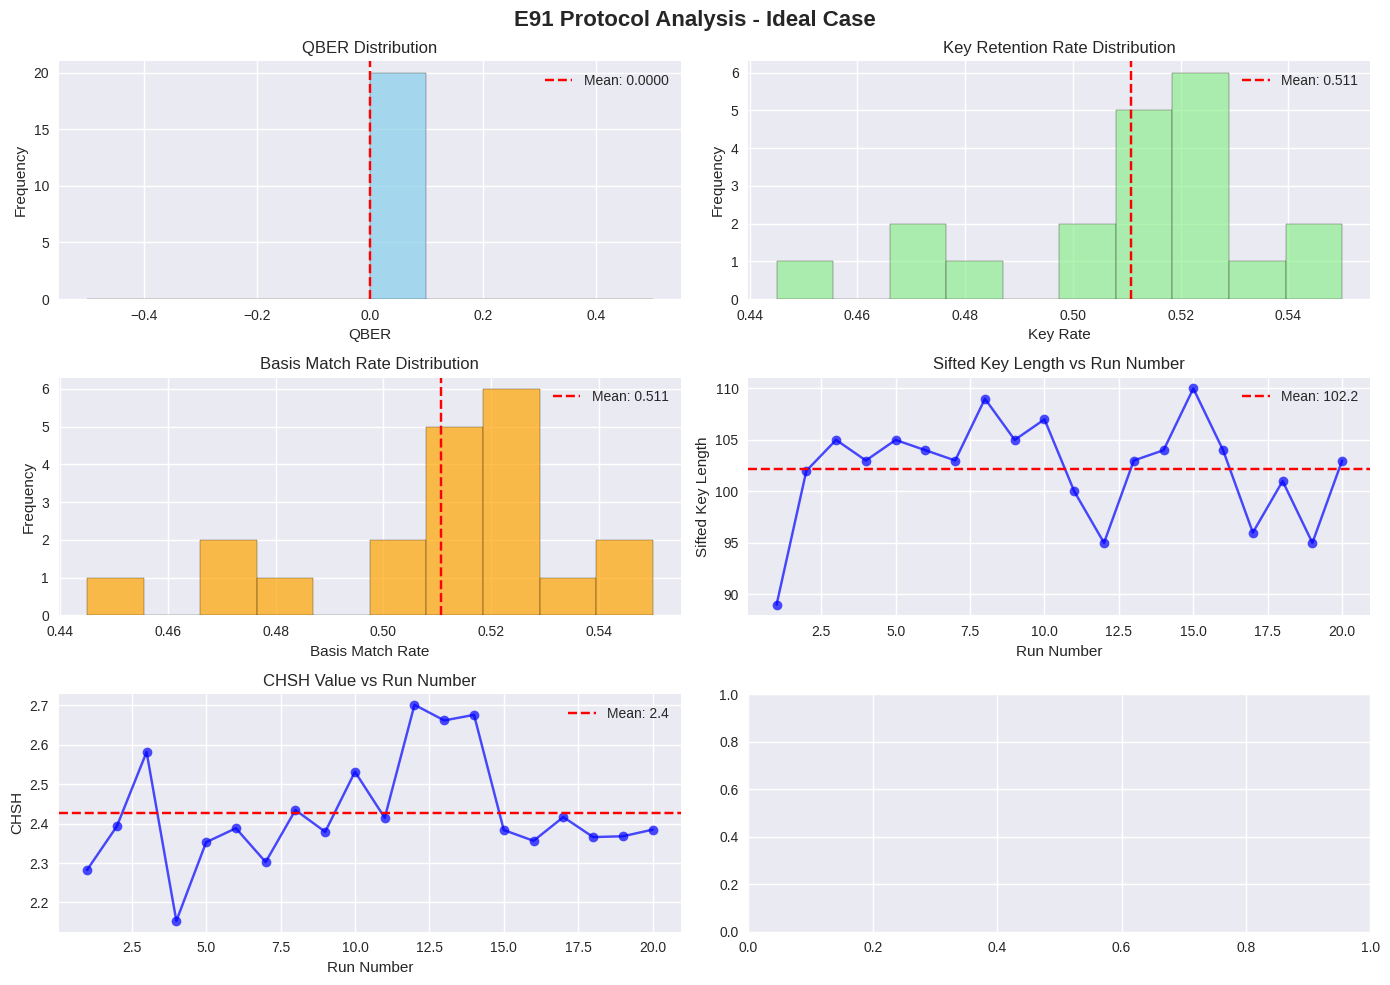

In [3]:
# Cell 3: E91 Metrics and Analysis

class E91MetricsAnalyzer:
    """
    Analyzer for E91 protocol metrics and performance evaluation
    """

    def __init__(self, e91_simulator):
        self.simulator = e91_simulator

    def calculate_qber(self, alice_bits, bob_bits):
        """
        Calculate Quantum Bit Error Rate (QBER)

        Args:
            alice_bits: Alice's bit sequence
            bob_bits: Bob's bit sequence

        Returns:
            float: QBER value (0.0 to 1.0)
        """
        if len(alice_bits) != len(bob_bits) or len(alice_bits) == 0:
            return 0.0

        errors = sum(1 for a, b in zip(alice_bits, bob_bits) if a != b)
        return errors / len(alice_bits)

    def calculate_key_retention_rate(self, raw_length, sifted_length):
        """
        Calculate the key retention rate after basis reconciliation

        Args:
            raw_length: Number of raw bits transmitted
            sifted_length: Number of bits in sifted key

        Returns:
            float: Key retention rate (0.0 to 1.0)
        """
        if raw_length == 0:
            return 0.0
        return sifted_length / raw_length

    def analyze_basis_distribution(self, alice_bases, bob_bases):
        """
        Analyze the distribution of basis choices

        Args:
            alice_bases: Alice's basis choices
            bob_bases: Bob's basis choices

        Returns:
            Dict: Analysis results
        """
        alice_basis_dist = Counter(alice_bases)
        bob_basis_dist = Counter(bob_bases)
        basis_matches = sum(1 for a, b in zip(alice_bases, bob_bases) if a == b)

        return {
            'alice_z_basis_count': alice_basis_dist.get(0, 0),
            'alice_x_basis_count': alice_basis_dist.get(1, 0),
            'bob_z_basis_count': bob_basis_dist.get(0, 0),
            'bob_x_basis_count': bob_basis_dist.get(1, 0),
            'basis_matches': basis_matches,
            'basis_match_rate': basis_matches / len(alice_bases) if alice_bases else 0
        }

    def comprehensive_analysis(self, num_runs=10, bits_per_run=200):
        """
        Perform comprehensive analysis over multiple runs

        Args:
            num_runs: Number of simulation runs
            bits_per_run: Number of bits per run

        Returns:
            Dict: Comprehensive analysis results
        """
        qber_values = []
        key_rates = []
        basis_match_rates = []
        sifted_key_lengths = []
        chsh = []

        print(f"Running comprehensive analysis: {num_runs} runs with {bits_per_run} bits each")
        print("-" * 60)

        for run in range(num_runs):
            # Run E91 simulation
            results = self.simulator.simulate_e91(bits_per_run)

            # Calculate metrics
            qber = self.calculate_qber(results['alice_sifted_key'], results['bob_sifted_key'])
            key_rate = self.calculate_key_retention_rate(results['raw_key_length'],
                                                       results['sifted_key_length'])
            basis_analysis = self.analyze_basis_distribution(results['alice_bases'],
                                                           results['bob_bases'])

            # Store results
            qber_values.append(qber)
            key_rates.append(key_rate)
            basis_match_rates.append(basis_analysis['basis_match_rate'])
            sifted_key_lengths.append(results['sifted_key_length'])
            chsh.append(results['chsh_value'])

            if (run + 1) % 2 == 0:
                print(f"Run {run + 1:2d}: Key rate = {key_rate:.3f}, "
                      f"QBER = {qber:.3f}, Sifted bits = {results['sifted_key_length']}"
                      f"CHSH = {results['chsh_value']}")

        # Calculate statistics
        analysis_results = {
            'num_runs': num_runs,
            'bits_per_run': bits_per_run,
            'qber_stats': {
                'mean': np.mean(qber_values),
                'std': np.std(qber_values),
                'min': np.min(qber_values),
                'max': np.max(qber_values)
            },
            'key_rate_stats': {
                'mean': np.mean(key_rates),
                'std': np.std(key_rates),
                'min': np.min(key_rates),
                'max': np.max(key_rates)
            },
            'basis_match_rate_stats': {
                'mean': np.mean(basis_match_rates),
                'std': np.std(basis_match_rates),
                'min': np.min(basis_match_rates),
                'max': np.max(basis_match_rates)
            },
            'sifted_key_length_stats': {
                'mean': np.mean(sifted_key_lengths),
                'std': np.std(sifted_key_lengths),
                'min': np.min(sifted_key_lengths),
                'max': np.max(sifted_key_lengths)
            },
            'chsh_value': {
                'mean': np.mean(chsh),
                'std': np.std(chsh),
                'min': np.min(chsh),
                'max': np.max(chsh)
            },
            'raw_data': {
                'qber_values': qber_values,
                'key_rates': key_rates,
                'basis_match_rates': basis_match_rates,
                'sifted_key_lengths': sifted_key_lengths,
                'chsh_value': chsh
            }
        }

        return analysis_results

    def plot_metrics(self, analysis_results):
        """
        Plot comprehensive metrics analysis

        Args:
            analysis_results: Results from comprehensive_analysis()
        """
        fig, axes = plt.subplots(3, 2, figsize=(14, 10))
        fig.suptitle('E91 Protocol Analysis - Ideal Case', fontsize=16, fontweight='bold')

        # QBER distribution
        axes[0, 0].hist(analysis_results['raw_data']['qber_values'], bins=10,
                       alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('QBER Distribution')
        axes[0, 0].set_xlabel('QBER')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(analysis_results['qber_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['qber_stats']['mean']:.4f}")
        axes[0, 0].legend()

        # Key rate distribution
        axes[0, 1].hist(analysis_results['raw_data']['key_rates'], bins=10,
                       alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 1].set_title('Key Retention Rate Distribution')
        axes[0, 1].set_xlabel('Key Rate')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].axvline(analysis_results['key_rate_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['key_rate_stats']['mean']:.3f}")
        axes[0, 1].legend()

        # Basis match rate distribution
        axes[1, 0].hist(analysis_results['raw_data']['basis_match_rates'], bins=10,
                       alpha=0.7, color='orange', edgecolor='black')
        axes[1, 0].set_title('Basis Match Rate Distribution')
        axes[1, 0].set_xlabel('Basis Match Rate')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(analysis_results['basis_match_rate_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['basis_match_rate_stats']['mean']:.3f}")
        axes[1, 0].legend()

        # Sifted key length over runs
        axes[1, 1].plot(range(1, analysis_results['num_runs'] + 1),
                       analysis_results['raw_data']['sifted_key_lengths'],
                       'bo-', alpha=0.7)
        axes[1, 1].set_title('Sifted Key Length vs Run Number')
        axes[1, 1].set_xlabel('Run Number')
        axes[1, 1].set_ylabel('Sifted Key Length')
        axes[1, 1].axhline(analysis_results['sifted_key_length_stats']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['sifted_key_length_stats']['mean']:.1f}")
        axes[1, 1].legend()

        # CHSH Value over runs
        axes[2, 0].plot(range(1, analysis_results['num_runs'] + 1),
                       analysis_results['raw_data']['chsh_value'],
                       'bo-', alpha=0.7)
        axes[2, 0].set_title('CHSH Value vs Run Number')
        axes[2, 0].set_xlabel('Run Number')
        axes[2, 0].set_ylabel('CHSH')
        axes[2, 0].axhline(analysis_results['chsh_value']['mean'],
                          color='red', linestyle='--',
                          label=f"Mean: {analysis_results['chsh_value']['mean']:.1f}")
        axes[2, 0].legend()

        plt.tight_layout()
        plt.show()

# Create metrics analyzer and run comprehensive analysis
print("\n" + "="*60)
print("E91 METRICS AND ANALYSIS")
print("="*60)

metrics_analyzer = E91MetricsAnalyzer(e91_sim)

# Run comprehensive analysis
analysis_results = metrics_analyzer.comprehensive_analysis(num_runs=20, bits_per_run=200)

print("\n" + "-"*60)
print("ANALYSIS SUMMARY")
print("-"*60)
print(f"Number of runs: {analysis_results['num_runs']}")
print(f"Bits per run: {analysis_results['bits_per_run']}")
print(f"\nQBER Statistics:")
print(f"  Mean: {analysis_results['qber_stats']['mean']:.6f}")
print(f"  Std:  {analysis_results['qber_stats']['std']:.6f}")
print(f"  Min:  {analysis_results['qber_stats']['min']:.6f}")
print(f"  Max:  {analysis_results['qber_stats']['max']:.6f}")

print(f"\nKey Retention Rate Statistics:")
print(f"  Mean: {analysis_results['key_rate_stats']['mean']:.4f}")
print(f"  Std:  {analysis_results['key_rate_stats']['std']:.4f}")
print(f"  Min:  {analysis_results['key_rate_stats']['min']:.4f}")
print(f"  Max:  {analysis_results['key_rate_stats']['max']:.4f}")

print(f"\nBasis Match Rate Statistics:")
print(f"  Mean: {analysis_results['basis_match_rate_stats']['mean']:.4f}")
print(f"  Std:  {analysis_results['basis_match_rate_stats']['std']:.4f}")

print(f"\nSifted Key Length Statistics:")
print(f"  Mean: {analysis_results['sifted_key_length_stats']['mean']:.1f}")
print(f"  Std:  {analysis_results['sifted_key_length_stats']['std']:.1f}")

print("\n" + "="*60)
print("KEY FINDINGS (Ideal Case):")
print("="*60)
print("• QBER should be 0.000 (no errors in ideal case)")

# Plot the metrics
metrics_analyzer.plot_metrics(analysis_results)

# Add CHSH analysis

In [4]:
# Draft/Test Implementation:
# Measurement angles (in radians)
# Alice: A0 = Z (0), A1 = X (π/2)
# Bob:   B0 = (Z + X)/√2 ≈ π/4, B1 = (Z - X)/√2 ≈ -π/4
basis_angles = {
    'A0': 0,
    'A1': np.pi / 2,
    'B0': np.pi / 4,
    'B1': -np.pi / 4
}

# Function to rotate qubit for given measurement basis
def apply_basis_rotation(circuit, qubit, angle):
    circuit.append(cirq.ry(-angle).on(qubit))

# Build E91 entangled pair + measurement circuit
def build_e91_circuit(choice_A, choice_B, bit_flip_prob=0.01):
    qA, qB = cirq.LineQubit.range(2)
    circuit = cirq.Circuit()

    # Entangle the qubits: Bell state
    circuit.append([cirq.H(qA), cirq.CNOT(qA, qB)])

    # Add local bit-flip noise (modeling channel noise)
    circuit.append([cirq.bit_flip(bit_flip_prob).on(qA), cirq.bit_flip(bit_flip_prob).on(qB)])

    # Apply measurement basis rotations
    apply_basis_rotation(circuit, qA, basis_angles[choice_A])
    apply_basis_rotation(circuit, qB, basis_angles[choice_B])

    # Measure both qubits
    circuit.append([cirq.measure(qA, key='a'), cirq.measure(qB, key='b')])

    return circuit, (qA, qB)

# Single trial simulation with given basis choices
def run_e91_trial(seed, choice_A, choice_B):
    random.seed(seed)
    np.random.seed(seed)

    circuit, _ = build_e91_circuit(choice_A, choice_B)

    simulator = cirq.DensityMatrixSimulator(seed=seed)
    result = simulator.run(circuit, repetitions=1)

    a = int(result.measurements['a'][0][0])
    b = int(result.measurements['b'][0][0])
    return (-1)**a, (-1)**b  # Convert 0 → +1, 1 → -1

# Compute expectation value E(Ai, Bj)
def compute_expectation(trial_seeds, choice_A, choice_B):
    results = [run_e91_trial(seed, choice_A, choice_B) for seed in trial_seeds]
    correlations = [a * b for (a, b) in results]
    return np.mean(correlations)

# Compute CHSH value: S = E(A0,B0) + E(A0,B1) + E(A1,B0) - E(A1,B1)
def compute_chsh(trial_seeds):
    E00 = compute_expectation(trial_seeds, 'A0', 'B0')
    E01 = compute_expectation(trial_seeds, 'A0', 'B1')
    E10 = compute_expectation(trial_seeds, 'A1', 'B0')
    E11 = compute_expectation(trial_seeds, 'A1', 'B1')
    return E00 + E01 + E10 - E11

# Monte Carlo setup
num_trials = 1000
master_seed = 123
random.seed(master_seed)
trial_seeds = [random.randint(0, 2**32 - 1) for _ in range(num_trials)]

# Run and print CHSH value
chsh_value = compute_chsh(trial_seeds)
print(f"Estimated CHSH value: {chsh_value:.3f}")


Estimated CHSH value: 2.836
